In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
from IPython.display import display
from scipy.interpolate import interp1d
import seaborn as sns
import qgrid
qgrid.set_grid_option('forceFitColumns', False)
from tqdm import tqdm

In [3]:
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [4]:
from pathlib import Path
data_dir = Path("/home/di40438/bachelorarbeit/data/")

data = {}
for csv_file in data_dir.glob("*.csv"):
    if csv_file.stem in ["schmelzen", "FormateCC4"]:continue
        
    this_csv = pd.read_csv(csv_file, delimiter=";")
    
    this_csv['DATE_TIME'] = pd.to_datetime(this_csv['TIME'],unit='s').dt.tz_localize("UTC")
    this_csv = this_csv.set_index('DATE_TIME', drop=False).sort_index()
    
    data[csv_file.stem] = this_csv.sort_values("TIME")
    #display( data[csv_file.stem].tail())
    
data['TundishTemperaturInC'] = data['TundishTemperaturInC'][(data['TundishTemperaturInC']['TundishTemperaturInC'] < 1600) & (data['TundishTemperaturInC']['TundishTemperaturInC'] > 1400)]  
    

### Import and further Preprocessing of schmelzen Dataframe

In [7]:
df_schmelzen = pd.read_pickle("/home/di40438/bachelorarbeit/dataschmelzen.pkl")

In [7]:
cols_schmelzen = ['ChargenNr',
 'ChargenNrErsteSchmInSeq',
 'GiessBeginnSchmelze',
 'GiessBeginn_DateTime',
 'GiessEndeSchmelze',
 'GiessEnde_DateTime',
 'EndeSchmelze',
 'Ende_DateTime',
 'NrSchmelzeInSequenz',
 'LiquidusTempInC',
 'SolidusTempInC',
 'UeberhitzungMittelInK',
 'ZielTempTreiberInC',
 'Str1SollGiessGeschwInMproMin',
 'Str2SollGiessGeschwInMproMin',
 'Str1Format',
 'Str2Format',
 'C-Aequiv01',
 'C-Aequiv02',
 'C-AequivP']

#### Add 90 minutes to the end of the last melting process of a sequence

In [10]:
df_schmelzen['EndeSchmelze'] = df_schmelzen['GiessEndeSchmelze']

df_schmelzen['ChargenNrErsteSchmInSeq_shifted'] = df_schmelzen['ChargenNrErsteSchmInSeq'].shift(-1)
df_schmelzen = df_schmelzen.fillna(0)

def add_time_to_end(row):               
        if row['ChargenNrErsteSchmInSeq'] !=  row['ChargenNrErsteSchmInSeq_shifted']:
            row['EndeSchmelze'] = row['EndeSchmelze'] + 90*60   #add 90 min to end of last 'GiessEnde' 
        return row

df_schmelzen = df_schmelzen.apply(add_time_to_end, axis=1)

df_schmelzen['Ende_DateTime'] = pd.to_datetime(df_schmelzen['EndeSchmelze'],unit='s').dt.tz_localize("UTC")

df_schmelzen = df_schmelzen.drop("ChargenNrErsteSchmInSeq_shifted", axis=1)

df_schmelzen = df_schmelzen[cols_schmelzen]

## Combine df_schmelzen and Laenge Sequenz with 90min added to 'GiessEnde'

In [13]:
merged = []

for _, row in data['Str1GiessLaengeSequenzInM'].iterrows():
    schmelze = df_schmelzen[(df_schmelzen["GiessBeginn_DateTime"] < row["DATE_TIME"]) & (df_schmelzen["Ende_DateTime"] >= row["DATE_TIME"])]
    if len(schmelze) != 1:
        continue
    merged.append(pd.concat([row.to_frame().transpose().reset_index(drop=True), schmelze.reset_index(drop=True)], axis=1))

df_str1_extended = pd.concat(merged)
df_str1_extended = df_str1_extended.reset_index(drop=True)

## Combine df_schmelzen and Laenge Sequenz

In [15]:
merged = []

for _, row in data['Str1GiessLaengeSequenzInM'].iterrows():
    schmelze = df_schmelzen[(df_schmelzen["GiessBeginn_DateTime"] < row["DATE_TIME"]) & (df_schmelzen["GiessEnde_DateTime"] >= row["DATE_TIME"])]
    if len(schmelze) != 1:
        continue
    merged.append(pd.concat([row.to_frame().transpose().reset_index(drop=True), schmelze.reset_index(drop=True)], axis=1))

df_merged_str1 = pd.concat(merged)
df_merged_str1 = df_merged_str1.reset_index(drop=True)

## Combine df_schmelzen and Laenge Schmelze nothing added to 'GiessEnde'

In [17]:
merged = []

for _, row in data['Str1GiessLaengeSchmelzeInM'].iterrows():
    schmelze = df_schmelzen[(df_schmelzen["GiessBeginn_DateTime"] < row["DATE_TIME"]) & (df_schmelzen["GiessEnde_DateTime"] >= row["DATE_TIME"])]
    if len(schmelze) != 1:
        continue
    merged.append(pd.concat([row.to_frame().transpose().reset_index(drop=True), schmelze.reset_index(drop=True)], axis=1))

df_str1_schmelzen = pd.concat(merged)
df_str1_schmelzen = df_str1_schmelzen.reset_index(drop=True)

## Create interpolated Data

### Interpolated Sequence data

In [19]:
df_seq_str1 = data['Str1GiessLaengeSequenzInM'].copy()

df_seq_str1 = df_seq_str1[df_seq_str1['DATE_TIME'] >= '2019-05-15 11:30:00+00:00' ]

In [21]:
rng = pd.date_range(start='2019-05-15 11:31:00+00:00', end='2019-08-30 23:59:00+00:00', freq='30s')
df_times = pd.DataFrame({'DateTime': rng})
df_times['ts'] = df_times.DateTime.values.astype(np.int64) // 10**9    #np arry by values, then 10**9 for ns

time = df_seq_str1['TIME'].to_numpy() 
length = df_seq_str1['Str1GiessLaengeSequenzInM'].to_numpy()

from scipy.interpolate import interp1d
interp_s = interp1d(time, length, kind='linear')

new_time = df_times['ts'].to_numpy()

inter_array = interp_s(new_time)

str1_inter = pd.DataFrame({'DATE_TIME':new_time , 'Str1GiessLaengeSequenzInM': inter_array, 'TIME': new_time})
str1_inter['DATE_TIME'] = pd.to_datetime(str1_inter['DATE_TIME'],unit='s').dt.tz_localize("UTC")
str1_inter.head()

## Combine df_schmelzen and str1_inter with 90min added to 'GiessEnde'

In [24]:
merged = []

for _, row in str1_inter.iterrows():
    schmelze = df_schmelzen[(df_schmelzen["GiessBeginn_DateTime"] < row["DATE_TIME"]) & (df_schmelzen["Ende_DateTime"] >= row["DATE_TIME"])]
    if len(schmelze) != 1:
        continue
    merged.append(pd.concat([row.to_frame().transpose().reset_index(drop=True), schmelze.reset_index(drop=True)], axis=1))

str1_inter_extended = pd.concat(merged)
str1_inter_extended = str1_inter_extended.reset_index(drop=True)

## Combine df_schmelzen and str1_inter (nothing added)

In [28]:
merged = []

for _, row in str1_inter.iterrows():
    schmelze = df_schmelzen[(df_schmelzen["GiessBeginn_DateTime"] < row["DATE_TIME"]) & (df_schmelzen["GiessEnde_DateTime"] >= row["DATE_TIME"])]
    if len(schmelze) != 1:
        continue
    merged.append(pd.concat([row.to_frame().transpose().reset_index(drop=True), schmelze.reset_index(drop=True)], axis=1))

df_str1_inter = pd.concat(merged)
df_str1_inter = df_str1_inter.reset_index(drop=True)

### Outliar detection: Get Outliars with Schmelzen data

In [46]:
str1_schmelzen = pd.read_pickle("/home/di40438/bachelorarbeit/data/df_str1_schmelzen.pkl")
str1_schmelzen.head()

,TIME,Str1GiessLaengeSchmelzeInM,DATE_TIME,ChargenNr,ChargenNrErsteSchmInSeq,GiessBeginnSchmelze,GiessBeginn_DateTime,GiessEndeSchmelze,GiessEnde_DateTime,EndeSchmelze,Ende_DateTime,NrSchmelzeInSequenz,LiquidusTempInC,SolidusTempInC,UeberhitzungMittelInK,ZielTempTreiberInC,Str1SollGiessGeschwInMproMin,Str2SollGiessGeschwInMproMin,Str1Format,Str2Format,C-Aequiv01,C-Aequiv02,C-AequivP
0,1557920384,0.35,2019-05-15 11:39:44+00:00,471719,471719,1.557920e+09,2019-05-15 11:39:23.490000010+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1,1517.8,1470.357,53.2,720,0.315,0.315,2235,2235,0.31285,0.32335,0.131067
1,1557920445,0.366,2019-05-15 11:40:45+00:00,471719,471719,1.557920e+09,2019-05-15 11:39:23.490000010+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1,1517.8,1470.357,53.2,720,0.315,0.315,2235,2235,0.31285,0.32335,0.131067
2,1557920506,0.465,2019-05-15 11:41:46+00:00,471719,471719,1.557920e+09,2019-05-15 11:39:23.490000010+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1,1517.8,1470.357,53.2,720,0.315,0.315,2235,2235,0.31285,0.32335,0.131067
3,1557920567,0.614,2019-05-15 11:42:47+00:00,471719,471719,1.557920e+09,2019-05-15 11:39:23.490000010+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1,1517.8,1470.357,53.2,720,0.315,0.315,2235,2235,0.31285,0.32335,0.131067
4,1557920628,0.831,2019-05-15 11:43:48+00:00,471719,471719,1.557920e+09,2019-05-15 11:39:23.490000010+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1,1517.8,1470.357,53.2,720,0.315,0.315,2235,2235,0.31285,0.32335,0.131067


In [47]:
str1_schmelzen_grouped = str1_schmelzen.groupby(str1_schmelzen['ChargenNr'])
df_schmelzen_max = str1_schmelzen_grouped['Str1GiessLaengeSchmelzeInM'].max().to_frame()
df_schmelzen_max = df_schmelzen_max.rename(columns={'Str1GiessLaengeSchmelzeInM': 'Str1GiessLaengeSchmelzeInM_max'})
df_schmelzen_max = df_schmelzen_max.reset_index(drop=False)

In [48]:
df_schmelzen_max.min()

ChargenNr                         471719.0
Str1GiessLaengeSchmelzeInM_max         0.0
dtype: float64

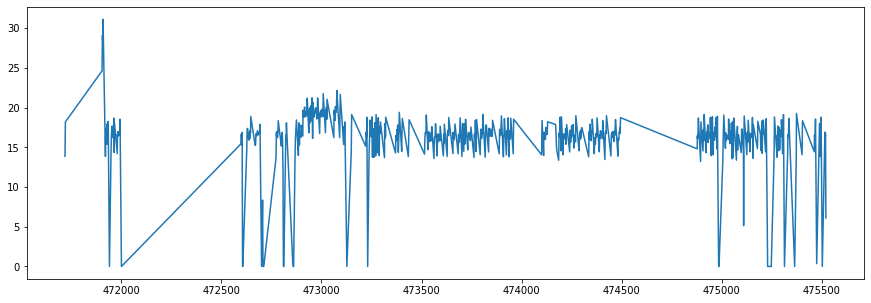

In [49]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,1,1)
ax1.plot('ChargenNr', 'Str1GiessLaengeSchmelzeInM_max', data = df_schmelzen_max)

In [55]:
df_schmelzen_max.tail()

,ChargenNr,Str1GiessLaengeSchmelzeInM_max
740,475515,16.840
741,475516,16.924
742,475517,16.173
743,475518,16.695
744,475520,6.093


In [50]:
schmelzen_drop = df_schmelzen_max[df_schmelzen_max['Str1GiessLaengeSchmelzeInM_max']<10]
schmelzen_drop = schmelzen_drop['ChargenNr'].to_numpy()
schmelzen_drop

array([471941, 472001, 472605, 472606, 472607, 472701, 472706, 472708,
       472710, 472712, 472810, 472812, 472857, 472859, 472861, 473127,
       473231, 474984, 474985, 474986, 475109, 475229, 475247, 475313,
       475364, 475474, 475502, 475520])

In [37]:
# str1_schmelzen[str1_schmelzen['ChargenNr']==473127]

### identify the sequences of schmelzen_drop

In [51]:
schmelzen = pd.read_pickle("/home/di40438/bachelorarbeit/data/df_schmelzen.pkl")

schmelzen = schmelzen.set_index('ChargenNr',drop=True)

seq_drop = schmelzen.loc[schmelzen_drop]

seq_drop = seq_drop['ChargenNrErsteSchmInSeq']
seq_drop = seq_drop.drop_duplicates(keep='first')
seq_drop = seq_drop.reset_index(drop=True)

In [52]:
#

0     471941
1     472001
2     472598
3     472701
4     472706
5     472800
6     472857
7     473127
8     473231
9     474984
10    475108
11    475229
12    475247
13    475313
14    475364
15    475474
16    475502
17    475513
Name: ChargenNrErsteSchmInSeq, dtype: int64

### Look at min charge

In [89]:
str1_schmelzen = pd.read_pickle("/home/di40438/bachelorarbeit/data/df_str1_schmelzen.pkl")
str1_schmelzen.head()

,TIME,Str1GiessLaengeSchmelzeInM,DATE_TIME,ChargenNr,ChargenNrErsteSchmInSeq,GiessBeginnSchmelze,GiessBeginn_DateTime,GiessEndeSchmelze,GiessEnde_DateTime,EndeSchmelze,Ende_DateTime,NrSchmelzeInSequenz,LiquidusTempInC,SolidusTempInC,UeberhitzungMittelInK,ZielTempTreiberInC,Str1SollGiessGeschwInMproMin,Str2SollGiessGeschwInMproMin,Str1Format,Str2Format,C-Aequiv01,C-Aequiv02,C-AequivP
0,1557920384,0.35,2019-05-15 11:39:44+00:00,471719,471719,1.557920e+09,2019-05-15 11:39:23.490000010+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1,1517.8,1470.357,53.2,720,0.315,0.315,2235,2235,0.31285,0.32335,0.131067
1,1557920445,0.366,2019-05-15 11:40:45+00:00,471719,471719,1.557920e+09,2019-05-15 11:39:23.490000010+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1,1517.8,1470.357,53.2,720,0.315,0.315,2235,2235,0.31285,0.32335,0.131067
2,1557920506,0.465,2019-05-15 11:41:46+00:00,471719,471719,1.557920e+09,2019-05-15 11:39:23.490000010+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1,1517.8,1470.357,53.2,720,0.315,0.315,2235,2235,0.31285,0.32335,0.131067
3,1557920567,0.614,2019-05-15 11:42:47+00:00,471719,471719,1.557920e+09,2019-05-15 11:39:23.490000010+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1,1517.8,1470.357,53.2,720,0.315,0.315,2235,2235,0.31285,0.32335,0.131067
4,1557920628,0.831,2019-05-15 11:43:48+00:00,471719,471719,1.557920e+09,2019-05-15 11:39:23.490000010+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1,1517.8,1470.357,53.2,720,0.315,0.315,2235,2235,0.31285,0.32335,0.131067


In [90]:
str1_schmelzen_grouped = str1_schmelzen.groupby(str1_schmelzen['ChargenNr'])
df_schmelzen_min = str1_schmelzen_grouped['Str1GiessLaengeSchmelzeInM'].min().to_frame()
df_schmelzen_min = df_schmelzen_min.rename(columns={'Str1GiessLaengeSchmelzeInM': 'Str1GiessLaengeSchmelzeInM_min'})
df_schmelzen_min = df_schmelzen_min.reset_index(drop=False)

In [91]:
# df_schmelzen_min.head()

,ChargenNr,Str1GiessLaengeSchmelzeInM_min
0,471719,0.005
1,471720,0.004
2,471721,0.000
3,471904,0.005
4,471905,0.002


In [92]:
# df_schmelzen_min.max()

ChargenNr                         475520.000
Str1GiessLaengeSchmelzeInM_min         0.434
dtype: float64

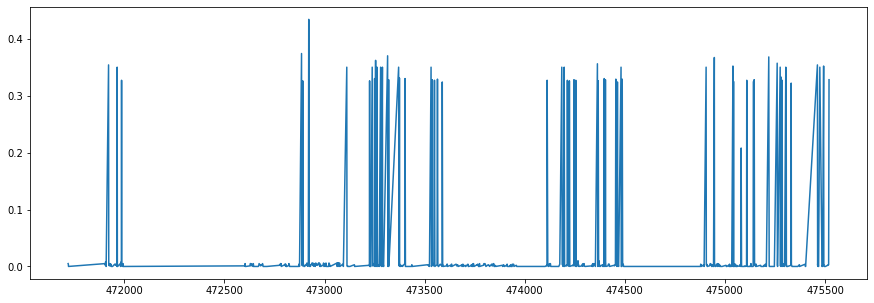

In [93]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,1,1)
ax1.plot('ChargenNr', 'Str1GiessLaengeSchmelzeInM_min', data = df_schmelzen_min)

## Drop Sequences - create df_strang_1

In [97]:
df_interv = df_interv.set_index(df_interv['ChargenNrErsteSchmInSeq'],drop=True)
df_interv = df_interv.drop(seq_drop, axis=0)
df_interv = df_interv.reset_index(drop=True)


## Create df_chargen_nr

### calculate min and max for each charge

In [100]:
df_interv_grouped = df_interv.groupby(df_interv['ChargenNr'])

df_interv_grouped_max = df_interv_grouped['Str1GiessLaengeSequenzInM'].max().to_frame()
df_interv_grouped_min = df_interv_grouped['Str1GiessLaengeSequenzInM'].min().to_frame()

df_interv_grouped_max = df_interv_grouped_max.rename(columns={'Str1GiessLaengeSequenzInM': 'Str1GiessLaengeSequenzInM_max'})

df_interv_grouped_min = df_interv_grouped_min.rename(columns={'Str1GiessLaengeSequenzInM': 'Str1GiessLaengeSequenzInM_min'})

chargen_nr = pd.merge(df_interv_grouped_min,df_interv_grouped_max,on=['ChargenNr'],
                                            how='outer')

chargen_nr = chargen_nr.reset_index(drop=False)

#### set min = 0:

In [104]:
def set_value_to_zero (row):
    if row['Str1GiessLaengeSequenzInM_min'] < 1:
        row['Str1GiessLaengeSequenzInM_min'] = 0
    return row


chargen_zero = chargen_nr.apply(set_value_to_zero, axis=1)

### Merge df_schmelzen and chargen_zero to get seq_id

In [107]:
df_chargen = pd.merge(chargen_zero,df_schmelzen[['ChargenNr','ChargenNrErsteSchmInSeq']],on=['ChargenNr'],
                                            how='inner')
df_chargen = pd.merge(df_chargen,df_schmelzen[['ChargenNr','GiessBeginn_DateTime']],on=['ChargenNr'],
                                            how='inner')  #to sort the values, sometimes the chargen_nr is not ascending order

df_chargen =df_chargen.set_index('GiessBeginn_DateTime', drop=False).sort_index()

df_chargen = df_chargen.reset_index(drop=True)
df_chargen = df_chargen.drop('GiessBeginn_DateTime', axis=1)

### chargen_old

In [109]:
df_chargen_old = df_chargen.copy()

#### set 'Str1GiessLaengeSequenzInM_min' of i equal to 'Str1GiessLaengeSequenzInM_max' of i-1

df_chargen['Str1GiessLaengeSequenzInM_max_prev'] = df_chargen['Str1GiessLaengeSequenzInM_max'].shift(1)
df_chargen['ChargenNrErsteSchmInSeq_prev'] = df_chargen['ChargenNrErsteSchmInSeq'].shift(1)

def set_min (row):
    if row['ChargenNrErsteSchmInSeq_prev'] == row['ChargenNrErsteSchmInSeq']:
        row['Str1GiessLaengeSequenzInM_min'] = row['Str1GiessLaengeSequenzInM_max_prev']
    return row

df_chargen_nr = df_chargen.apply(set_min, axis=1)
df_chargen_nr = df_chargen_nr.drop(['Str1GiessLaengeSequenzInM_max_prev','ChargenNrErsteSchmInSeq_prev' ], axis=1)

In [114]:
df_chargen_nr.head()

,ChargenNr,Str1GiessLaengeSequenzInM_min,Str1GiessLaengeSequenzInM_max,ChargenNrErsteSchmInSeq
0,471719.0,0.000000,13.796115,471719.0
1,471720.0,13.796115,30.519066,471719.0
2,471721.0,30.519066,85.844002,471719.0
3,471904.0,0.000000,24.633606,471904.0
4,471905.0,24.633606,52.145854,471904.0


## Remove time dependence by assigning the specific cooling zone in which each section is 

In [12]:
def get_charNr(time, seq_nr):
        return df_schmelzen.loc[(((df_schmelzen['GiessBeginnSchmelze'] <= time) & (df_schmelzen['EndeSchmelze'] >= time)) & (df_schmelzen['ChargenNrErsteSchmInSeq'] == seq_nr)), ['ChargenNr']].to_numpy()[0][0]

In [28]:
df_schmelzen = pd.read_pickle("/home/di40438/bachelorarbeit/data/df_schmelzen.pkl")

def get_charNr(time, seq_nr):
    try:
        return df_schmelzen.loc[(((df_schmelzen['GiessBeginnSchmelze'] <= time) & (df_schmelzen['EndeSchmelze'] >= time)) & (df_schmelzen['ChargenNrErsteSchmInSeq'] == seq_nr)), ['ChargenNr']].to_numpy()[0][0]
    except IndexError:
        return df_schmelzen.loc[(((df_schmelzen['GiessBeginnSchmelze'] <= np.round(time.item(),-1)) & (df_schmelzen['EndeSchmelze'] >=  np.round(time.item(),-1))) & (df_schmelzen['ChargenNrErsteSchmInSeq'] == seq_nr)), ['ChargenNr']].to_numpy()[0][0]

def charNr(row):
    time =row['z1_begin_time']
    row['ChargenNr'] = get_charNr(time, row['SequenzNr'])
    return row    

df_chargen_nr = pd.read_pickle("/home/di40438/bachelorarbeit/data/chargen_nr.pkl")

# Zonen Start und Ende
zonen = {'z1':[0.62,2.17],'z2a':[2.17,3.52],'z2b':[3.52,5.44],'z3a':[5.44,7.18],'z3b':[7.18,9.1],'z4':[9.1,11.02],'z5':[11.02,14.42],'zpy':[15.42,15.42]}

# seq_max = pd.read_pickle("/home/di40438/bachelorarbeit/data/merged_1_all.pkl") #'sequenz_laenge' nur bis zum Giessende 
seq_drop = pd.read_pickle("/home/di40438/bachelorarbeit/data/seq_drop.pkl")

seq_max = pd.read_pickle("/home/di40438/bachelorarbeit/data/df_str1_inter.pkl") #'sequenz_laenge' nur bis zum Giessende 

seq_max = seq_max.set_index(seq_max['ChargenNrErsteSchmInSeq'],drop=True)

seq_max = seq_max.drop(seq_drop, axis=0)  #drop the chargen from the outliar detection (sequences were already dropped)

seq_max = seq_max.reset_index(drop=True)

str1_seq = pd.read_pickle("/home/di40438/bachelorarbeit/data/df_strang_1.pkl") #sequenz_laenge auch noch später als Giessende

sequence_nr = pd.read_pickle("/home/di40438/bachelorarbeit/data/df_strang_1.pkl")
sequence_nr = sequence_nr['ChargenNrErsteSchmInSeq']
sequence_nr = sequence_nr.drop_duplicates(keep='first')
sequence_nr = sequence_nr.reset_index(drop=True)

In [29]:
str1_data = {}
for sequence in tqdm(sequence_nr):   # für alle Sequenzen
    
    seq_max_length = seq_max[seq_max['ChargenNrErsteSchmInSeq']==sequence]
    seq_max_length = seq_max_length.reset_index(drop=True)

    seq = str1_seq[str1_seq['ChargenNrErsteSchmInSeq']==sequence]
    seq = seq.reset_index(drop=True)

    gil = seq['Str1GiessLaengeSequenzInM']  # Länge der Strecke, die das Förderband zurückgelegt hat
    max_gil = np.max(gil)   # maximale Länge der Strecke, die das Förderband zurückgelegt hat
    max_meter = np.max(seq_max_length['Str1GiessLaengeSequenzInM']) # tatsächliche maximale Länge der Schmelze 

    arr = np.arange(0, max_gil, 0.01)
    df_length = pd.DataFrame({'length': arr})

    time = seq['TIME'].to_numpy() 
    length = seq['Str1GiessLaengeSequenzInM'].to_numpy()

    from scipy.interpolate import interp1d
    interp = interp1d(length, time, kind='linear')  #x-Achse: Sequenzlänge, y-Achse: Zeitpunkte

    gilz = []
    cnt  = 0
    section_length = 0.33        #Länge der Abschnitte in Meter
    for section in range(int(np.max((max_meter+section_length)/section_length))):  #für jeden 0.33m-Abschnitt der Sequenz  
        gilz.append({})                                                            # (der ite Abschnitt)
        for z in zonen:        #jede Zone --> Verfolgen jedes Abschnitten durch jede Zone
            mnt = 0
            mxt = 0

            mnt = interp(zonen[z][0]+(section*section_length))   #die Länge des Stranges bei jedem Abschnitt
            mxt = interp(zonen[z][1]+((section+1)*section_length))
            dt  = mxt-mnt

            gilz[-1][z] = [mnt,mxt,dt]

    seq_df = pd.DataFrame()
    for section in range(len(gilz)):
        z_df = pd.DataFrame()
        for z in zonen:
            section_z_df = pd.DataFrame(gilz[section][z], index=[z+'_begin_time',z+'_end_time',z+'_delta_time']).transpose()
            z_df = pd.concat([z_df, section_z_df], axis=1)

        seq_df = pd.concat([seq_df,z_df], axis=0)

        seq_df['SequenzNr'] = seq['ChargenNrErsteSchmInSeq']
        seq_df = seq_df.apply(charNr, axis=1)
        seq_df = seq_df.reindex(sorted(seq_df.columns), axis=1)
        seq_df = seq_df.reset_index(drop=True)

        str1_data[sequence] = seq_df.copy()

100%|██████████| 100/100 [4:33:57<00:00, 164.37s/it]  


## combine all dataframes

In [1]:
str1_df = pd.DataFrame()
for seq_nr in list(str1_data.keys()):
     str1_df = pd.concat([str1_df,str1_data[seq_nr]], axis=0)


NameError: name 'pd' is not defined

## Add water of each zone

### Interpolation functions

In [12]:
discr = list(data.keys())

In [15]:
unwanted = {'TundishTemperaturInC',
 'Str1TempMittelLsInC',
 'Str1TempMittelFsInC',
 'Str2TempMittelLsInC',
 'Str2TempMittelFsInC','Str1GiessLaengeSchmelzeInM',
 'Str2GiessLaengeSchmelzeInM','Str1GiessLaengeSequenzInM',
 'Str2GiessLaengeSequenzInM','Str2AusfLaengeSchmelzeInM',
 'Str1AusfLaengeSchmelzeInM',
 'Str1GiessGeschwInMproMin',
 'Str2GiessGeschwInMproMin','Str2WasserZ1FsInLproMin',
 'Str2WasserZ1LsInLproMin',
 'Str2WasserZ2bFsInLproMin',
 'Str2WasserZ4FsInLproMin',
 'Str2WasserZ4LsInLproMin',
 'Str2WasserZ3bLsInLproMin',
 'Str2WasserZ3bFsInLproMin',
 'Str2WasserZ1DiefflenInLproMin',
 'Str2WasserZ2bLsInLproMin',
 'Str2WasserZ1DillingenInLproMin',
 'Str2WasserZ2aFsInLproMin',
 'Str2WasserZ2aLsInLproMin',
 'Str2WasserZ5FsInLproMin',
 'Str2WasserZ5LsInLproMin',
 'Str2WasserZ3aFsInLproMin',
 'Str2WasserZ3aLsInLproMin',
'Str1WasserZ1DiefflenInLproMin',
 'Str1WasserZ1DillingenInLproMin'} 
  
water_keys_str1 = [ele for ele in discr if ele not in unwanted] 

In [16]:
water_keys_str1 = sorted(water_keys_str1)
water_keys_str1

['Str1WasserZ1FsInLproMin',
 'Str1WasserZ1LsInLproMin',
 'Str1WasserZ2aFsInLproMin',
 'Str1WasserZ2aLsInLproMin',
 'Str1WasserZ2bFsInLproMin',
 'Str1WasserZ2bLsInLproMin',
 'Str1WasserZ3aFsInLproMin',
 'Str1WasserZ3aLsInLproMin',
 'Str1WasserZ3bFsInLproMin',
 'Str1WasserZ3bLsInLproMin',
 'Str1WasserZ4FsInLproMin',
 'Str1WasserZ4LsInLproMin',
 'Str1WasserZ5FsInLproMin',
 'Str1WasserZ5LsInLproMin']

In [17]:
interpol_func = {}
for key in water_keys_str1:
    name = key.replace('Str1Wasser','').replace('InLproMin','').replace('Z','z')
    minutes = data[key]['TIME'].to_numpy() / 60
    value = data[key][key].to_numpy()
    interpol_func[name] = interp1d(minutes,value, kind='linear')
    

In [18]:
import scipy
def integrate(X,z,side):
        Y = [interpol_func[z+side](x) for x in X]
        return scipy.integrate.trapz(Y,X, dx=1)

def trapz_integration(row):
    begin_m = row[z + '_begin_time'] / 60
    end_m = row[z + '_end_time'] / 60
    try:
        row['water_' + z + '_' + side + '_inL'] = integrate([begin_m, end_m],z,side)
        return row
    except ValueError:
        return np.nan
                  

In [19]:
zones_water = ['z1','z2a','z2b','z3a','z3b','z4','z5']
sides = ['Fs','Ls']
for side in tqdm(sides):
    for z in zones_water:
        str1_df = str1_df.apply(trapz_integration,axis=1)

100%|██████████| 2/2 [07:48<00:00, 234.17s/it]


In [20]:
str1_df.head()

,ith_section,ChargenNr,SequenzNr,z1_begin_time,z1_delta_time,z1_end_time,z2a_begin_time,z2a_delta_time,z2a_end_time,z2b_begin_time,z2b_delta_time,z2b_end_time,z3a_begin_time,z3a_delta_time,z3a_end_time,z3b_begin_time,z3b_delta_time,z3b_end_time,z4_begin_time,z4_delta_time,z4_end_time,z5_begin_time,z5_delta_time,z5_end_time,zpy_begin_time,zpy_delta_time,zpy_end_time,water_z1_Fs_inL,water_z2a_Fs_inL,water_z2b_Fs_inL,water_z3a_Fs_inL,water_z3b_Fs_inL,water_z4_Fs_inL,water_z5_Fs_inL,water_z1_Ls_inL,water_z2a_Ls_inL,water_z2b_Ls_inL,water_z3a_Ls_inL,water_z3b_Ls_inL,water_z4_Ls_inL,water_z5_Ls_inL
0,0,471719,471719,1557920566.3125696,382.462430,1557920948.775,1557920886.012461,320.012461,1557921206.0249221,1557921143.2125,429.096875,1557921572.309375,1557921509.4031873,393.633603,1557921903.0367906,1557921840.1592588,428.312616,1557922268.471875,1557922205.5986686,428.491956,1557922634.090625,1557922571.184375,710.360796,1557923281.5451713,1557923409.0560749,62.831425,1557923471.8875,3119.584193,785.352726,1187.230406,808.139696,749.253211,548.628705,459.342301,3398.427642,884.499304,877.341505,776.045471,669.922404,544.346736,457.823007
1,1,471719,471719,1557920651.8,359.881250,1557921011.68125,1557920948.775,320.059375,1557921268.834375,1557921206.0249221,429.090343,1557921635.115265,1557921572.309375,393.472704,1557921965.7820792,1557921903.0367906,428.323584,1557922331.3603745,1557922268.471875,428.509080,1557922696.9809554,1557922634.090625,710.268750,1557923344.359375,1557923471.8875,62.779167,1557923534.6666667,2910.690478,760.192160,1151.003847,825.622565,752.361875,537.545548,907.756962,3202.426662,870.373597,925.197282,799.139971,664.182810,544.567487,925.327828
2,2,471719,471719,1557920716.403125,358.184375,1557921074.5875,1557921011.68125,320.378037,1557921332.0592873,1557921268.834375,428.781724,1557921697.616099,1557921635.115265,393.532344,1557922028.6476092,1557921965.7820792,428.338137,1557922394.1202164,1557922331.3603745,428.375647,1557922759.7360215,1557922696.9809554,710.174808,1557923407.1557631,1557923534.6666667,62.842708,1557923597.509375,1826.863298,913.319936,1126.722101,810.464162,743.095802,538.491152,917.704124,2005.371073,933.500594,978.227550,789.609535,658.838653,544.596659,926.538478
3,3,471719,471719,1557920779.309375,358.184375,1557921137.49375,1557921074.5875,320.631250,1557921395.21875,1557921332.0592873,428.206338,1557921760.265625,1557921697.616099,393.786460,1557922091.4025595,1557922028.6476092,428.329401,1557922456.9770103,1557922394.1202164,428.498534,1557922822.61875,1557922759.7360215,710.245229,1557923469.98125,1557923597.509375,62.768021,1557923660.2773964,1873.686516,895.843446,1114.338374,787.884083,749.214432,539.758927,956.043039,2048.619264,903.401109,985.937317,774.524384,659.587064,544.917797,927.964232
4,4,471719,471719,1557920842.215625,358.108362,1557921200.3239875,1557921137.49375,320.512480,1557921458.0062306,1557921395.21875,427.837325,1557921823.0560749,1557921760.265625,393.995136,1557922154.260761,1557922091.4025595,428.332313,1557922519.734872,1557922456.9770103,428.547990,1557922885.525,1557922822.61875,710.147605,1557923532.766355,1557923660.2773964,62.710189,1557923722.9875858,1865.885814,894.711105,1152.121180,784.103937,755.343412,540.302650,917.806943,2042.069617,911.600693,1075.340751,780.262831,670.587743,545.119845,929.169427


### Add the mean of the temperatur at the pyrometer

### Mean with Integral

In [23]:
temp_keys = ['Str1TempMittelLsInC', 'Str1TempMittelFsInC']

from scipy.interpolate import interp1d
interpol_function_temp = {}
for key in temp_keys:
    minutes = data[key]['TIME'].to_numpy() / 60
    value = data[key][key].to_numpy()
    interpol_function_temp[key] = interp1d(minutes,value, kind='linear')

import scipy
def integrate_mean(X,key):
        Y = [interpol_function_temp[key](x) for x in X]
        return scipy.integrate.trapz(Y,X, dx=1)

def temp_mean(row):
    begin_t = row['zpy_begin_time'] / 60
    end_t= row['zpy_end_time'] / 60
    try:
        row[key + '_mean'] = (1 / (end_t - begin_t)) * integrate_mean([begin_t, end_t],key)
        return row
    except ValueError:
        return np.nan


In [24]:
for key in tqdm(temp_keys):
    str1_df = str1_df.apply(temp_mean,axis=1)

100%|██████████| 2/2 [01:06<00:00, 33.36s/it]


### Merge str1_df with df_schmelzen to get other attributes

In [28]:
str1_df = str1_df.rename(columns={'ChargenNr_begin': 'ChargenNr'})

In [32]:
str1_df = pd.merge(str1_df,df_schmelzen,on='ChargenNr',how='inner')                                        

In [33]:
str1_df.head()

,ith_section,ChargenNr,SequenzNr,z1_begin_time,z1_delta_time,z1_end_time,z2a_begin_time,z2a_delta_time,z2a_end_time,z2b_begin_time,z2b_delta_time,z2b_end_time,z3a_begin_time,z3a_delta_time,z3a_end_time,z3b_begin_time,z3b_delta_time,z3b_end_time,z4_begin_time,z4_delta_time,z4_end_time,z5_begin_time,z5_delta_time,z5_end_time,zpy_begin_time,zpy_delta_time,zpy_end_time,water_z1_Fs_inL,water_z2a_Fs_inL,water_z2b_Fs_inL,water_z3a_Fs_inL,water_z3b_Fs_inL,water_z4_Fs_inL,water_z5_Fs_inL,water_z1_Ls_inL,water_z2a_Ls_inL,water_z2b_Ls_inL,water_z3a_Ls_inL,water_z3b_Ls_inL,water_z4_Ls_inL,water_z5_Ls_inL,Str1TempMittelLsInC_mean,Str1TempMittelFsInC_mean,ChargenNrErsteSchmInSeq,GiessBeginnSchmelze,GiessBeginn_DateTime,GiessEndeSchmelze,GiessEnde_DateTime,EndeSchmelze,Ende_DateTime,NrSchmelzeInSequenz,LiquidusTempInC,SolidusTempInC,UeberhitzungMittelInK,ZielTempTreiberInC,Str1SollGiessGeschwInMproMin,Str2SollGiessGeschwInMproMin,Str1Format,Str2Format,C-Aequiv01,C-Aequiv02,C-AequivP
0,0,471719,471719,1557920566.3125696,382.462430,1557920948.775,1557920886.012461,320.012461,1557921206.0249221,1557921143.2125,429.096875,1557921572.309375,1557921509.4031873,393.633603,1557921903.0367906,1557921840.1592588,428.312616,1557922268.471875,1557922205.5986686,428.491956,1557922634.090625,1557922571.184375,710.360796,1557923281.5451713,1557923409.0560749,62.831425,1557923471.8875,3119.584193,785.352726,1187.230406,808.139696,749.253211,548.628705,459.342301,3398.427642,884.499304,877.341505,776.045471,669.922404,544.346736,457.823007,644.673707,642.421037,471719,1.557920e+09,2019-05-15 11:39:23.490000010+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1,1517.8,1470.357,53.2,720,0.315,0.315,2235,2235,0.31285,0.32335,0.131067
1,1,471719,471719,1557920651.8,359.881250,1557921011.68125,1557920948.775,320.059375,1557921268.834375,1557921206.0249221,429.090343,1557921635.115265,1557921572.309375,393.472704,1557921965.7820792,1557921903.0367906,428.323584,1557922331.3603745,1557922268.471875,428.509080,1557922696.9809554,1557922634.090625,710.268750,1557923344.359375,1557923471.8875,62.779167,1557923534.6666667,2910.690478,760.192160,1151.003847,825.622565,752.361875,537.545548,907.756962,3202.426662,870.373597,925.197282,799.139971,664.182810,544.567487,925.327828,718.550000,709.053366,471719,1.557920e+09,2019-05-15 11:39:23.490000010+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1,1517.8,1470.357,53.2,720,0.315,0.315,2235,2235,0.31285,0.32335,0.131067
2,2,471719,471719,1557920716.403125,358.184375,1557921074.5875,1557921011.68125,320.378037,1557921332.0592873,1557921268.834375,428.781724,1557921697.616099,1557921635.115265,393.532344,1557922028.6476092,1557921965.7820792,428.338137,1557922394.1202164,1557922331.3603745,428.375647,1557922759.7360215,1557922696.9809554,710.174808,1557923407.1557631,1557923534.6666667,62.842708,1557923597.509375,1826.863298,913.319936,1126.722101,810.464162,743.095802,538.491152,917.704124,2005.371073,933.500594,978.227550,789.609535,658.838653,544.596659,926.538478,753.119944,739.744555,471719,1.557920e+09,2019-05-15 11:39:23.490000010+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1,1517.8,1470.357,53.2,720,0.315,0.315,2235,2235,0.31285,0.32335,0.131067
3,3,471719,471719,1557920779.309375,358.184375,1557921137.49375,1557921074.5875,320.631250,1557921395.21875,1557921332.0592873,428.206338,1557921760.265625,1557921697.616099,393.786460,1557922091.4025595,1557922028.6476092,428.329401,1557922456.9770103,1557922394.1202164,428.498534,1557922822.61875,1557922759.7360215,710.245229,1557923469.98125,1557923597.509375,62.768021,1557923660.2773964,1873.686516,895.843446,1114.338374,787.884083,749.214432,539.758927,956.043039,2048.619264,903.401109,985.937317,774.524384,659.587064,544.917797,927.964232,758.572201,745.919112,471719,1.557920e+09,2019-05-15 11:39:23.49

### Sequence id

In [39]:
str1_df['strang_nr'] = 1

In [40]:
str1_df.head()

,ith_section,ChargenNr,SequenzNr,z1_begin_time,z1_delta_time,z1_end_time,z2a_begin_time,z2a_delta_time,z2a_end_time,z2b_begin_time,z2b_delta_time,z2b_end_time,z3a_begin_time,z3a_delta_time,z3a_end_time,z3b_begin_time,z3b_delta_time,z3b_end_time,z4_begin_time,z4_delta_time,z4_end_time,z5_begin_time,z5_delta_time,z5_end_time,zpy_begin_time,zpy_delta_time,zpy_end_time,water_z1_Fs_inL,water_z2a_Fs_inL,water_z2b_Fs_inL,water_z3a_Fs_inL,water_z3b_Fs_inL,water_z4_Fs_inL,water_z5_Fs_inL,water_z1_Ls_inL,water_z2a_Ls_inL,water_z2b_Ls_inL,water_z3a_Ls_inL,water_z3b_Ls_inL,water_z4_Ls_inL,water_z5_Ls_inL,Str1TempMittelLsInC_mean,Str1TempMittelFsInC_mean,ChargenNrErsteSchmInSeq,GiessBeginnSchmelze,GiessBeginn_DateTime,GiessEndeSchmelze,GiessEnde_DateTime,EndeSchmelze,Ende_DateTime,NrSchmelzeInSequenz,LiquidusTempInC,SolidusTempInC,UeberhitzungMittelInK,ZielTempTreiberInC,Str1SollGiessGeschwInMproMin,Str2SollGiessGeschwInMproMin,Str1Format,Str2Format,C-Aequiv01,C-Aequiv02,C-AequivP,strang_nr
0,0,471719,471719,1557920566.3125696,382.462430,1557920948.775,1557920886.012461,320.012461,1557921206.0249221,1557921143.2125,429.096875,1557921572.309375,1557921509.4031873,393.633603,1557921903.0367906,1557921840.1592588,428.312616,1557922268.471875,1557922205.5986686,428.491956,1557922634.090625,1557922571.184375,710.360796,1557923281.5451713,1557923409.0560749,62.831425,1557923471.8875,3119.584193,785.352726,1187.230406,808.139696,749.253211,548.628705,459.342301,3398.427642,884.499304,877.341505,776.045471,669.922404,544.346736,457.823007,644.673707,642.421037,471719,1.557920e+09,2019-05-15 11:39:23.490000010+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1,1517.8,1470.357,53.2,720,0.315,0.315,2235,2235,0.31285,0.32335,0.131067,1
1,1,471719,471719,1557920651.8,359.881250,1557921011.68125,1557920948.775,320.059375,1557921268.834375,1557921206.0249221,429.090343,1557921635.115265,1557921572.309375,393.472704,1557921965.7820792,1557921903.0367906,428.323584,1557922331.3603745,1557922268.471875,428.509080,1557922696.9809554,1557922634.090625,710.268750,1557923344.359375,1557923471.8875,62.779167,1557923534.6666667,2910.690478,760.192160,1151.003847,825.622565,752.361875,537.545548,907.756962,3202.426662,870.373597,925.197282,799.139971,664.182810,544.567487,925.327828,718.550000,709.053366,471719,1.557920e+09,2019-05-15 11:39:23.490000010+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1,1517.8,1470.357,53.2,720,0.315,0.315,2235,2235,0.31285,0.32335,0.131067,1
2,2,471719,471719,1557920716.403125,358.184375,1557921074.5875,1557921011.68125,320.378037,1557921332.0592873,1557921268.834375,428.781724,1557921697.616099,1557921635.115265,393.532344,1557922028.6476092,1557921965.7820792,428.338137,1557922394.1202164,1557922331.3603745,428.375647,1557922759.7360215,1557922696.9809554,710.174808,1557923407.1557631,1557923534.6666667,62.842708,1557923597.509375,1826.863298,913.319936,1126.722101,810.464162,743.095802,538.491152,917.704124,2005.371073,933.500594,978.227550,789.609535,658.838653,544.596659,926.538478,753.119944,739.744555,471719,1.557920e+09,2019-05-15 11:39:23.490000010+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1,1517.8,1470.357,53.2,720,0.315,0.315,2235,2235,0.31285,0.32335,0.131067,1
3,3,471719,471719,1557920779.309375,358.184375,1557921137.49375,1557921074.5875,320.631250,1557921395.21875,1557921332.0592873,428.206338,1557921760.265625,1557921697.616099,393.786460,1557922091.4025595,1557922028.6476092,428.329401,1557922456.9770103,1557922394.1202164,428.498534,1557922822.61875,1557922759.7360215,710.245229,1557923469.98125,1557923597.509375,62.768021,1557923660.2773964,1873.686516,895.843446,1114.338374,787.884083,749.214432,539.758927,956.043039,2048.619264,903.401109,985.937317,774.524384,659.587064,544.917797,927.964232,758.572201,745.919112,471719,1.557920e+09,2019-0

In [41]:
def seq_and_str_nr(row):
    row['seq_id'] = str(row['SequenzNr']) + '_str_' + str(row['strang_nr'])
    return row

str1_df = str1_df.apply(seq_and_str_nr, axis=1)

In [42]:
str1_df.head()

,ith_section,ChargenNr,SequenzNr,z1_begin_time,z1_delta_time,z1_end_time,z2a_begin_time,z2a_delta_time,z2a_end_time,z2b_begin_time,z2b_delta_time,z2b_end_time,z3a_begin_time,z3a_delta_time,z3a_end_time,z3b_begin_time,z3b_delta_time,z3b_end_time,z4_begin_time,z4_delta_time,z4_end_time,z5_begin_time,z5_delta_time,z5_end_time,zpy_begin_time,zpy_delta_time,zpy_end_time,water_z1_Fs_inL,water_z2a_Fs_inL,water_z2b_Fs_inL,water_z3a_Fs_inL,water_z3b_Fs_inL,water_z4_Fs_inL,water_z5_Fs_inL,water_z1_Ls_inL,water_z2a_Ls_inL,water_z2b_Ls_inL,water_z3a_Ls_inL,water_z3b_Ls_inL,water_z4_Ls_inL,water_z5_Ls_inL,Str1TempMittelLsInC_mean,Str1TempMittelFsInC_mean,ChargenNrErsteSchmInSeq,GiessBeginnSchmelze,GiessBeginn_DateTime,GiessEndeSchmelze,GiessEnde_DateTime,EndeSchmelze,Ende_DateTime,NrSchmelzeInSequenz,LiquidusTempInC,SolidusTempInC,UeberhitzungMittelInK,ZielTempTreiberInC,Str1SollGiessGeschwInMproMin,Str2SollGiessGeschwInMproMin,Str1Format,Str2Format,C-Aequiv01,C-Aequiv02,C-AequivP,strang_nr,seq_id
0,0,471719,471719,1557920566.3125696,382.462430,1557920948.775,1557920886.012461,320.012461,1557921206.0249221,1557921143.2125,429.096875,1557921572.309375,1557921509.4031873,393.633603,1557921903.0367906,1557921840.1592588,428.312616,1557922268.471875,1557922205.5986686,428.491956,1557922634.090625,1557922571.184375,710.360796,1557923281.5451713,1557923409.0560749,62.831425,1557923471.8875,3119.584193,785.352726,1187.230406,808.139696,749.253211,548.628705,459.342301,3398.427642,884.499304,877.341505,776.045471,669.922404,544.346736,457.823007,644.673707,642.421037,471719,1.557920e+09,2019-05-15 11:39:23.490000010+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1,1517.8,1470.357,53.2,720,0.315,0.315,2235,2235,0.31285,0.32335,0.131067,1,471719_str_1
1,1,471719,471719,1557920651.8,359.881250,1557921011.68125,1557920948.775,320.059375,1557921268.834375,1557921206.0249221,429.090343,1557921635.115265,1557921572.309375,393.472704,1557921965.7820792,1557921903.0367906,428.323584,1557922331.3603745,1557922268.471875,428.509080,1557922696.9809554,1557922634.090625,710.268750,1557923344.359375,1557923471.8875,62.779167,1557923534.6666667,2910.690478,760.192160,1151.003847,825.622565,752.361875,537.545548,907.756962,3202.426662,870.373597,925.197282,799.139971,664.182810,544.567487,925.327828,718.550000,709.053366,471719,1.557920e+09,2019-05-15 11:39:23.490000010+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1,1517.8,1470.357,53.2,720,0.315,0.315,2235,2235,0.31285,0.32335,0.131067,1,471719_str_1
2,2,471719,471719,1557920716.403125,358.184375,1557921074.5875,1557921011.68125,320.378037,1557921332.0592873,1557921268.834375,428.781724,1557921697.616099,1557921635.115265,393.532344,1557922028.6476092,1557921965.7820792,428.338137,1557922394.1202164,1557922331.3603745,428.375647,1557922759.7360215,1557922696.9809554,710.174808,1557923407.1557631,1557923534.6666667,62.842708,1557923597.509375,1826.863298,913.319936,1126.722101,810.464162,743.095802,538.491152,917.704124,2005.371073,933.500594,978.227550,789.609535,658.838653,544.596659,926.538478,753.119944,739.744555,471719,1.557920e+09,2019-05-15 11:39:23.490000010+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1,1517.8,1470.357,53.2,720,0.315,0.315,2235,2235,0.31285,0.32335,0.131067,1,471719_str_1
3,3,471719,471719,1557920779.309375,358.184375,1557921137.49375,1557921074.5875,320.631250,1557921395.21875,1557921332.0592873,428.206338,1557921760.265625,1557921697.616099,393.786460,1557922091.4025595,1557922028.6476092,428.329401,1557922456.9770103,1557922394.1202164,428.498534,1557922822.61875,1557922759.7360215,710.245229,1557923469.98125,1557923597.509375,62.768021,1557923660.2773964,1873.686516,895.843446,1114.338374,787.884083,749.214432,539.758927,956.043039,2048.619264,903.401109,985.937317,774.524384,659.587064,544.917797,927.964232,75

In [43]:
str1_df_v2 = str1_df.drop(['Str2Format','Str2SollGiessGeschwInMproMin'],axis=1).rename(
    columns={'Str1Format': 'Format', 'Str1SollGiessGeschwInMproMin': 'SollGiessGeschwInMproMin' })

str1_df_v2.head()

,ith_section,ChargenNr,SequenzNr,z1_begin_time,z1_delta_time,z1_end_time,z2a_begin_time,z2a_delta_time,z2a_end_time,z2b_begin_time,z2b_delta_time,z2b_end_time,z3a_begin_time,z3a_delta_time,z3a_end_time,z3b_begin_time,z3b_delta_time,z3b_end_time,z4_begin_time,z4_delta_time,z4_end_time,z5_begin_time,z5_delta_time,z5_end_time,zpy_begin_time,zpy_delta_time,zpy_end_time,water_z1_Fs_inL,water_z2a_Fs_inL,water_z2b_Fs_inL,water_z3a_Fs_inL,water_z3b_Fs_inL,water_z4_Fs_inL,water_z5_Fs_inL,water_z1_Ls_inL,water_z2a_Ls_inL,water_z2b_Ls_inL,water_z3a_Ls_inL,water_z3b_Ls_inL,water_z4_Ls_inL,water_z5_Ls_inL,Str1TempMittelLsInC_mean,Str1TempMittelFsInC_mean,ChargenNrErsteSchmInSeq,GiessBeginnSchmelze,GiessBeginn_DateTime,GiessEndeSchmelze,GiessEnde_DateTime,EndeSchmelze,Ende_DateTime,NrSchmelzeInSequenz,LiquidusTempInC,SolidusTempInC,UeberhitzungMittelInK,ZielTempTreiberInC,SollGiessGeschwInMproMin,Format,C-Aequiv01,C-Aequiv02,C-AequivP,strang_nr,seq_id
0,0,471719,471719,1557920566.3125696,382.462430,1557920948.775,1557920886.012461,320.012461,1557921206.0249221,1557921143.2125,429.096875,1557921572.309375,1557921509.4031873,393.633603,1557921903.0367906,1557921840.1592588,428.312616,1557922268.471875,1557922205.5986686,428.491956,1557922634.090625,1557922571.184375,710.360796,1557923281.5451713,1557923409.0560749,62.831425,1557923471.8875,3119.584193,785.352726,1187.230406,808.139696,749.253211,548.628705,459.342301,3398.427642,884.499304,877.341505,776.045471,669.922404,544.346736,457.823007,644.673707,642.421037,471719,1.557920e+09,2019-05-15 11:39:23.490000010+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1,1517.8,1470.357,53.2,720,0.315,2235,0.31285,0.32335,0.131067,1,471719_str_1
1,1,471719,471719,1557920651.8,359.881250,1557921011.68125,1557920948.775,320.059375,1557921268.834375,1557921206.0249221,429.090343,1557921635.115265,1557921572.309375,393.472704,1557921965.7820792,1557921903.0367906,428.323584,1557922331.3603745,1557922268.471875,428.509080,1557922696.9809554,1557922634.090625,710.268750,1557923344.359375,1557923471.8875,62.779167,1557923534.6666667,2910.690478,760.192160,1151.003847,825.622565,752.361875,537.545548,907.756962,3202.426662,870.373597,925.197282,799.139971,664.182810,544.567487,925.327828,718.550000,709.053366,471719,1.557920e+09,2019-05-15 11:39:23.490000010+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1,1517.8,1470.357,53.2,720,0.315,2235,0.31285,0.32335,0.131067,1,471719_str_1
2,2,471719,471719,1557920716.403125,358.184375,1557921074.5875,1557921011.68125,320.378037,1557921332.0592873,1557921268.834375,428.781724,1557921697.616099,1557921635.115265,393.532344,1557922028.6476092,1557921965.7820792,428.338137,1557922394.1202164,1557922331.3603745,428.375647,1557922759.7360215,1557922696.9809554,710.174808,1557923407.1557631,1557923534.6666667,62.842708,1557923597.509375,1826.863298,913.319936,1126.722101,810.464162,743.095802,538.491152,917.704124,2005.371073,933.500594,978.227550,789.609535,658.838653,544.596659,926.538478,753.119944,739.744555,471719,1.557920e+09,2019-05-15 11:39:23.490000010+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1,1517.8,1470.357,53.2,720,0.315,2235,0.31285,0.32335,0.131067,1,471719_str_1
3,3,471719,471719,1557920779.309375,358.184375,1557921137.49375,1557921074.5875,320.631250,1557921395.21875,1557921332.0592873,428.206338,1557921760.265625,1557921697.616099,393.786460,1557922091.4025595,1557922028.6476092,428.329401,1557922456.9770103,1557922394.1202164,428.498534,1557922822.61875,1557922759.7360215,710.245229,1557923469.98125,1557923597.509375,62.768021,1557923660.2773964,1873.686516,895.843446,1114.338374,787.884083,749.214432,539.758927,956.043039,2048.619264,903.401109,985.937317,774.524384,659.587064,544.917797,927.964232,758.572201,745.919112,471719,1.557920e+09,2019-05-15 11:39:23.490000010+00:00,1.557